# Описание

Решение задачи классификации точек наиболее эффективно. Для этого в работе необходимо применить различные методы по отбору признаков. Отбор признаков предпочтительнее осуществлять основываясь на математическом аппарате, поэтому данные для этого задания будут сгенерированы, чтобы избежать признаков с физическим смыслом.

## Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    VarianceThreshold,
    f_classif,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# константы
RANDOM_STATE = 42

## Этап 1: Генерация данных

In [2]:
x_data_generated, y_data_generated = make_classification(
    scale=1, random_state=RANDOM_STATE
)

# Преобразуем в DataFrame для удобства
X = pd.DataFrame(x_data_generated)
y = pd.Series(y_data_generated)

## Этап 2: Модель логистической регрессии и оценка точности

In [3]:
log_reg = LogisticRegression()
accuracy_initial = cross_val_score(log_reg, X, y, scoring="accuracy").mean()
print(f"Средняя точность модели логистической регрессии:\n {accuracy_initial:.2f}")

Средняя точность модели логистической регрессии:
 0.98


## Этап 3: Статистический отбор признаков

### a) Матрица корреляции

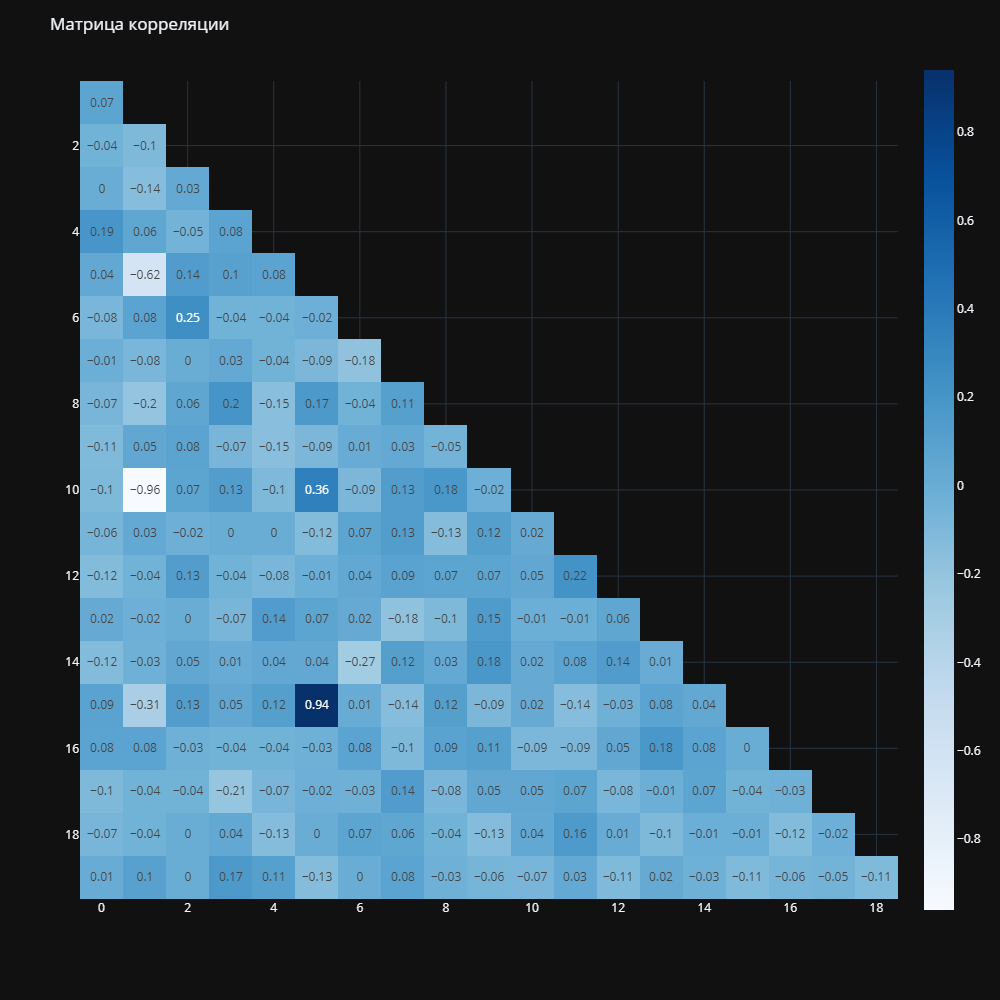

In [4]:
# Assuming X is your DataFrame
correlation_matrix = X.corr().round(2)

# Create a mask for the upper triangle
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Apply the mask and drop NaN values correctly
df_corr_viz = (
    correlation_matrix.mask(mask).dropna(how="all", axis=0).dropna(how="all", axis=1)
)

# Visualization
fig = px.imshow(
    df_corr_viz,
    text_auto=True,
    width=1000,
    height=1000,
    color_continuous_scale=px.colors.sequential.Blues,
)
fig.update_layout(title="Матрица корреляции", showlegend=False, template="plotly_dark")
fig.show("png")

Сильная корреляция между:

1 и 5

1 и 10

5 и 15

Дропнем 1 и 5 признаки.

In [5]:
high_corr_features = [1, 5]
X_corr = X.drop(columns=high_corr_features)

## b) Отсечение низковариативных признаков

In [6]:
X_corr.var()

0     0.987254
2     1.232789
3     0.961548
4     0.746691
6     0.863241
7     0.863802
8     1.212926
9     0.948552
10    1.752861
11    1.041794
12    0.863090
13    1.301697
14    1.059838
15    0.801004
16    0.945848
17    1.116600
18    0.980808
19    0.821459
dtype: float64

In [7]:
threshold = 1.0  # Порог для корреляции
selector = VarianceThreshold(threshold)
X_var = selector.fit_transform(X_corr)
# Получаем индексы признаков, которые прошли отбор
selected_indices = selector.get_support(indices=True)
print("Индексы выбранных признаков:", selected_indices)

Индексы выбранных признаков: [ 1  6  8  9 11 12 15]


In [8]:
# Найдем названия отсеченных признаков
dropped_features = np.setdiff1d(np.arange(X.shape[1]), selected_indices)
print("Индексы отсеченных признаков:", dropped_features)

Индексы отсеченных признаков: [ 0  2  3  4  5  7 10 13 14 16 17 18 19]


In [9]:
# Повторная оценка точности для отобранных признаков
accuracy_corr = cross_val_score(log_reg, X_corr, y, scoring="accuracy").mean()
accuracy_var = cross_val_score(log_reg, X_var, y, scoring="accuracy").mean()
print(
    f"Средняя точность модели логистической регрессии после удаления признаков с высокой корреляцией:\n {accuracy_corr:.2f}"
)
print(
    f"Средняя точность модели логистической регрессии после удаления низковариативных признаков:\n {accuracy_var:.2f}"
)

Средняя точность модели логистической регрессии после удаления признаков с высокой корреляцией:
 0.96
Средняя точность модели логистической регрессии после удаления низковариативных признаков:
 0.93


## Этап 4: Дисперсионный анализ

In [10]:
select_k_best = SelectKBest(score_func=f_classif, k=5)
X_kbest = select_k_best.fit_transform(X, y)
accuracy_kbest = cross_val_score(log_reg, X_kbest, y, scoring="accuracy").mean()
print(f"Средняя точность модели KBest:\n {accuracy_kbest:.2f}")

Средняя точность модели KBest:
 0.98


## Этап 5: Отбор с использованием моделей

### a) Логистическая регрессия с L1 регуляризацией

In [11]:
sfm_log_reg = SelectFromModel(
    LogisticRegression(penalty="l1", solver="liblinear", random_state=RANDOM_STATE)
)
X_sfm_log = sfm_log_reg.fit_transform(X, y)
accuracy_sfm_log = cross_val_score(log_reg, X_sfm_log, y, scoring="accuracy").mean()
print(
    f"Средняя точность модели логистической регрессии с L1 регуляризацией:\n {accuracy_sfm_log:.2f}"
)

Средняя точность модели логистической регрессии с L1 регуляризацией:
 0.98


### b) Cлучайный лес

In [12]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X, y)
importances = rf.feature_importances_
feature_indices = np.argsort(importances)[::-1]
X_rf = X.iloc[:, feature_indices[:5]]  # Возьмем 5 наиболее важных признаков
accuracy_rf = cross_val_score(log_reg, X_rf, y, scoring="accuracy").mean()
print(f"Средняя точность модели случайного леса:\n {accuracy_rf:.2f}")

Средняя точность модели случайного леса:
 0.98


## Этап 6: Перебор признаков

In [13]:
selector_sfs = SequentialFeatureSelector(log_reg)
selector_sfs.fit(X, y)
X_sfs = selector_sfs.transform(X)
accuracy_sfs = cross_val_score(log_reg, X_sfs, y, scoring="accuracy").mean()
print(f"Средняя точность перебора признаков:\n {accuracy_sfs:.2f}")

Средняя точность перебора признаков:
 1.00


Соберем все полученные результаты в одну таблицу

In [14]:
# Формирование таблицы результатов
results = pd.DataFrame(
    {
        "Способ выбора признаков": [
            "Исходный набор",
            "Корреляция",
            "Низковариативные",
            "Дисперсионный анализ",
            "Логистическая регрессия (L1)",
            "Random Forest",
            "Перебор признаков",
        ],
        "Количество признаков": [
            X.shape[1],
            X_corr.shape[1],
            X_var.shape[1],
            X_kbest.shape[1],
            X_sfm_log.shape[1],
            X_rf.shape[1],
            X_sfs.shape[1],
        ],
        "Средняя точность модели": [
            accuracy_initial,
            accuracy_corr,
            accuracy_var,
            accuracy_kbest,
            accuracy_sfm_log,
            accuracy_rf,
            accuracy_sfs,
        ],
    }
)

# Вывод

В рамках данного задания была проведена работа по отбору признаков с использованием различных методов. Основной целью было улучшение классификации точек с помощью логистической регрессии.

### Этапы работы

1. **Генерация данных**: Данные были сгенерированы с помощью функции `make_classification` из библиотеки `sklearn`. Использовалось 1000 образцов и 20 признаков.

2. **Модель логистической регрессии**: Для начальной проверки точности модели была использована логистическая регрессия. Средняя точность на исходном наборе признаков составила 0.98.

3. **Статистический отбор признаков**:
   - **Корреляция**: Из 20 признаков были выбраны 18 на основе матрицы корреляции. Средняя точность при использовании этих признаков составила 0.96.
   - **Низковариативные признаки**: После применения `VarianceThreshold` число признаков уменьшилось до 7, а точность модели составила 0.93.
   - **Дисперсионный анализ**: При использовании функции `SelectKBest` было выбрано 5 лучших признаков, что дало точность 0.98.

4. **Отбор с использованием моделей**:
   - Логистическая регрессия с L1 регуляризацией отобрала 9 признаков с точностью 0.98.
   - Модель Random Forest выбрала 5 наиболее важных признаков с аналогичной точностью 0.98.

5. **Перебор признаков**: Метод `SequentialFeatureSelector` также позволил выбрать 10 признаков, что дало наилучший результат — точность модели составила 1.00.

In [15]:
# Выводим таблицу
results

,Способ выбора признаков,Количество признаков,Средняя точность модели
0,Исходный набор,20,0.98
1,Корреляция,18,0.96
2,Низковариативные,7,0.93
3,Дисперсионный анализ,5,0.98
4,Логистическая регрессия (L1),9,0.98
5,Random Forest,5,0.98
6,Перебор признаков,10,1.00


### Заключение

На основании проделанной работы можно сделать вывод, что для задачи классификации точек эффективнее всего использовать метод перебора признаков, который продемонстрировал наилучшие результаты с точностью 1.00. В то же время, другие методы, такие как использование модели Random Forest и логистической регрессии с L1 регуляризацией, также показали высокую точность и могут быть использованы в зависимости от конкретных требований задачи.